In [2]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import scipy as sp
import pymaster as nmt
from tqdm import tqdm

In [3]:
def get_Cl(nside, mode):
    lmax = 3*nside-1
    l = np.arange(lmax+1)
    C_l = 1/l**2
    C_l[0:2] = 0
    
    # sigmab = hp.nside2resol(nside) 
    # fwhm = (8*np.log(2))**0.5 * sigmab
    # bl = hp.gauss_beam(fwhm, lmax)
    
    if mode == 'EE':
        C_l = np.array([np.zeros_like(C_l), C_l, np.zeros_like(C_l), np.zeros_like(C_l)]) # TT EE BB TE
    if mode == 'BB':
        C_l = np.array([np.zeros_like(C_l), np.zeros_like(C_l), C_l, np.zeros_like(C_l)])
    return C_l #* bl**2

In [4]:
def P_l2(ll, z):
    P2 = 3*(1-z**2)
    P3 = 5*z*P2
    P = [0,0,P2,P3]
    if len(ll) <= 4:
        P = P[:ll.max()+1]
    else:
        for l in range(4, ll.max()+1):
            P.append( ( (2*l-1) * z * P[l-1] - (l+1) * P[l-2] ) / (l-2) )
    return np.pad(np.array(P), (np.abs(ll.min()),0))

In [5]:
#bicep implementation

def get_a_ij(r_i, r_j):    
    z_hat = np.array([0,0,1])

    n_ij = np.cross(r_i, r_j)#/np.linalg.norm(np.cross(r_i, r_j))
    n_i = np.cross(r_i, z_hat)#/np.linalg.norm(np.cross(r_i, z_hat))

    a_ij = np.arctan2( np.dot(np.cross(n_ij, n_i), r_i), np.dot(n_ij, n_i) )
        
    return a_ij

def get_R(a):
    return np.array([
        [np.cos(2*a), -np.sin(2*a)],
        [np.sin(2*a), np.cos(2*a)]
    ])

In [6]:
def F_12(l, z):
    if np.round(z, 15) == 1:
        return 0.5*np.ones_like(l) 
    if np.round(z, 15) == -1:
        # print('z=-1')
        return 0.5*(-1)**l
    else:
        F = 2 * ( ((l+2)*z)/(1-z**2) * P_l2(l-1,z) - ((l-4)/(1-z**2) + l*(l-1)/2) * P_l2(l,z) ) / ((l-1)*l*(l+1)*(l+2))
        F[0:2] = 0     
        return F 
        
def F_22(l, z):
    if np.round(z, 15) == 1:
        return -0.5*np.ones_like(l) 
    if np.round(z, 15) == -1:
        # print('z=-1')
        return 0.5*(-1)**l
    else:
        F = 4 * ( (l+2)*P_l2(l-1,z) - (l-1)*z*P_l2(l,z) ) / ( (l-1)*l*(l+1)*(l+2)*(1-z**2) )
        F[0:2] = 0
        return F

In [7]:
def QQ_ij(l, Cl, z):
    return np.sum( (2*l+1) /(4*np.pi) * (F_12(l,z)*Cl[1] - F_22(l,z)*Cl[2]) )

def UU_ij(l, Cl, z):
    return np.sum( (2*l+1) /(4*np.pi) * (F_12(l,z)*Cl[2] - F_22(l,z)*Cl[1]) )

def get_M_ij(l, Cl, z):
    QQ = QQ_ij(l, Cl, z)
    UU = UU_ij(l, Cl, z)
    return np.array([
        [QQ, np.zeros_like(QQ)],
        [np.zeros_like(UU), UU]
    ])

In [8]:
def C_ana(nside, Cl, mask=None):
    lmax = 3*nside-1
    npix = 12*nside**2
    l = np.arange(lmax+1)

    if mask is None:
        pix = range(npix)    
        C = np.zeros((2*npix, 2*npix))
        
    else:
        pix = np.where(mask!=0)[0]
        row = []
        col = []
        data = []
    
    for i in tqdm(pix):
        for j in pix:
            if i == j:
                a_ij = 0
                a_ji = 0
                z = 1
            else:
                r_i = hp.pix2vec(nside, i)  
                r_j = hp.pix2vec(nside, j)
                z = np.dot(r_i, r_j)
                # print(i, j)
                a_ij = get_a_ij(r_i, r_j)
                a_ji = get_a_ij(r_j, r_i)
                
            R_ij = get_R(a_ij)
            R_ji = get_R(a_ji)
            
            M = get_M_ij(l, Cl, z)
            cov = R_ij.T @ M @ R_ji

            if mask is None:
                C[i][j] = cov[0][0]
                C[i][j+npix] = cov[0][1]
                C[i+npix][j] = cov[1][0]
                C[i+npix][j+npix] = cov[1][1]   
                
            else:
                row.append(i)
                col.append(j)
                data.append(cov[0][0])
    
                row.append(i)
                col.append(j+npix)
                data.append(cov[0][1])
    
                row.append(i+npix)
                col.append(j)
                data.append(cov[1][0])
    
                row.append(i+npix)
                col.append(j+npix)
                data.append(cov[1][1])

    if mask is not None:
        C = sp.sparse.coo_array((data, (row, col)), shape=(2*npix, 2*npix))
        
    assert np.abs(C-C.T).max() < 1e-15
    
    return C

In [9]:
nside = 64
lmax = 3*nside-1
npix = 12*nside**2
l = np.arange(lmax+1)
c2d = l*(l+1)/2/np.pi

hits = hp.read_map(f'obsmat_nside{nside}/out/0/filterbin_hits.fits')
non_zero = np.where(hits!=0)[0]

mask = np.zeros_like(hits)
mask[non_zero] = 1
mask_apo = nmt.mask_apodization(mask, 8, apotype='C2')

Z = sp.sparse.diags_array(mask_apo)
ZZ = sp.sparse.block_diag([Z, Z])

R_unapo = sp.sparse.load_npz(f'obsmat_nside{nside}/obsmat.npz')[npix:, npix:] #Gets QU 
R = ZZ @ R_unapo

Cl_EEonly = get_Cl(nside, 'EE')
Cl_BBonly = get_Cl(nside, 'BB')

/tmp/ipykernel_4913/3391188291.py:4: RuntimeWarning: divide by zero encountered in divide
  C_l = 1/l**2


In [9]:
# nmc = 1024
# C_mc = np.zeros((2*npix, 2*npix))

# for i in range(nmc):
#     np.random.seed(i)
#     m = hp.synfast(Cl_EEonly, nside, new=True)    
#     m -= np.mean(m)
#     m_QU = np.concatenate([m[1], m[2]])
#     C_mc += np.outer(m_QU, m_QU)

# C_mc /= nmc

In [10]:
# C_E = C_ana(nside, Cl_EEonly, mask)
# C_B = C_ana(nside, Cl_BBonly, mask)

# sp.sparse.save_npz(f'C_E_{nside}', C_E)
# sp.sparse.save_npz(f'C_B_{nside}', C_B)

  0%|                                                    | 0/52 [00:00<?, ?it/s]/tmp/ipykernel_14421/623331083.py:8: RuntimeWarning: invalid value encountered in divide
  F = 2 * ( ((l+2)*z)/(1-z**2) * P_l2(l-1,z) - ((l-4)/(1-z**2) + l*(l-1)/2) * P_l2(l,z) ) / ((l-1)*l*(l+1)*(l+2))
/tmp/ipykernel_14421/623331083.py:19: RuntimeWarning: invalid value encountered in divide
  F = 4 * ( (l+2)*P_l2(l-1,z) - (l-1)*z*P_l2(l,z) ) / ( (l-1)*l*(l+1)*(l+2)*(1-z**2) )
100%|███████████████████████████████████████████| 52/52 [00:02<00:00, 17.90it/s]


In [10]:
C_E = sp.sparse.load_npz(f'C_E_{nside}.npz')
C_B = sp.sparse.load_npz(f'C_B_{nside}.npz')

In [11]:
obs_C_E = R @ C_E @ R.T
obs_C_B = R @ C_B @ R.T

In [ ]:
# sparse
diag_E = obs_C_E.diagonal()
diag_B = obs_C_B.diagonal()

sigma = (np.mean(diag_E[diag_E!=0]) + np.mean(diag_B[diag_B!=0])) / 2 /1000
factor = sp.sparse.identity(obs_C_E.shape[0])*sigma**2

In [25]:
eigs, v = sp.sparse.linalg.eigsh(obs_C_B+factor, 2000, obs_C_E+factor)

In [26]:
# #dense
# diag_E = np.diag(obs_C_E.toarray())
# diag_B = np.diag(obs_C_B.toarray())

# sigma = (np.mean(diag_E[diag_E!=0]) + np.mean(diag_B[diag_B!=0])) /2 /1000
# factor = np.eye(C_E.shape[0]) * sigma **2

# eigs, v = sp.linalg.eigh(obs_C_B.toarray()+factor, obs_C_E.toarray()+factor)

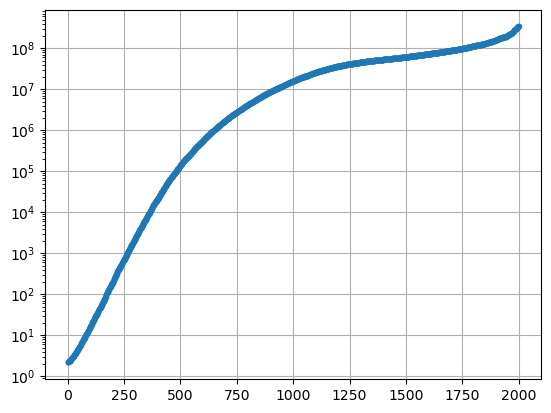

In [27]:
plt.plot(eigs, marker='.', linestyle='None')
plt.semilogy()
plt.grid()

In [28]:
# ambi = 0
# for eig in eigsh:
#     if np.isclose(eig, 1):
#         ambi += 1
# ambi / len(eigs)

In [29]:
# purification
cut = 1.02
pass_cut = np.where(eigs >= cut)[0]

In [30]:
pure_b = v[:, pass_cut]
pure_b.shape

(98304, 2000)

In [31]:
pure_b[:,0] @ pure_b[:,-1]

-35756.15436395793

In [33]:
mask_QU = np.concatenate([mask, mask])
zeros = np.where(mask_QU==0)[0]

for i in range(pure_b.shape[1]):    
    pure_b[:,i][zeros] = 0
    pure_b[:,i] /= np.linalg.norm(pure_b[:,i], axis=0)

pure_b[:,0] @ pure_b[:,-1]

-0.0001843358174970543

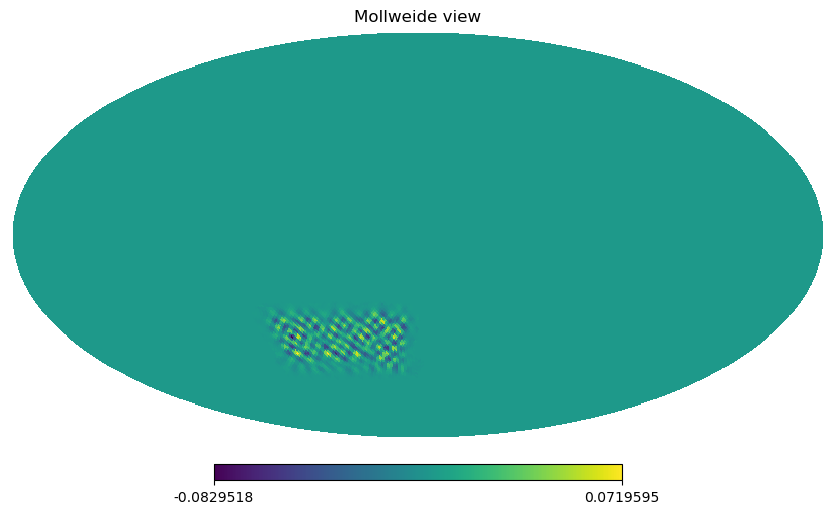

In [42]:
hp.mollview(pure_b[:,-100].reshape(2, npix)[0])

In [43]:
#Sparse
pure_b = sp.sparse.csr_array(pure_b)
pure_b

<98304x2000 sparse array of type '<class 'numpy.float64'>'
	with 9036000 stored elements in Compressed Sparse Row format>

In [62]:
pi_b = pure_b @ sp.sparse.linalg.inv(pure_b.T @ pure_b) @ pure_b.T
# pi_b = pure_b @ pure_b.T
pi_b

<98304x98304 sparse array of type '<class 'numpy.float64'>'
	with 20412324 stored elements in Compressed Sparse Row format>

In [63]:
sp.sparse.linalg.eigsh(pi_b, 3, return_eigenvectors=False)

array([1., 1., 1.])

In [64]:
#dense
# pi_b = pure_b @ pure_b.T
# pi_b = pure_b @ np.linalg.inv(pure_b.T @ pure_b) @ pure_b.T
# e,_ = sp.linalg.eigh(pi_b)
# e

In [73]:
#Test the purification

b = nmt.NmtBin.from_nside_linear(nside, 16)
ells = b.get_effective_ells()
c2db = ells * (ells+1) /2/np.pi

nmc = 64

cl = np.zeros((nmc, len(ells)))
cl_pure = np.zeros((nmc, len(ells)))

for i in tqdm(range(nmc)):
    np.random.seed(i)
    m = hp.synfast(Cl_BBonly, nside, new=True)
    obs_QU = R @ m[1:].flatten()
    pure_QU =  pi_b @ obs_QU
    
    f = nmt.NmtField(mask_apo, mask*obs_QU.reshape(2,npix), purify_b=False)
    cl[i] = nmt.compute_full_master(f, f, b)[3]

    f = nmt.NmtField(mask_apo, mask*obs_QU.reshape(2, npix), purify_b=True)
    cl_pure[i] = nmt.compute_full_master(f, f, b)[3] 

mean = np.mean(cl, axis=0)
std = np.std(cl, axis=0)

mean_pure = np.mean(cl_pure, axis=0)
std_pure = np.std(cl_pure, axis=0)

100%|███████████████████████████████████████████| 64/64 [00:16<00:00,  3.93it/s]


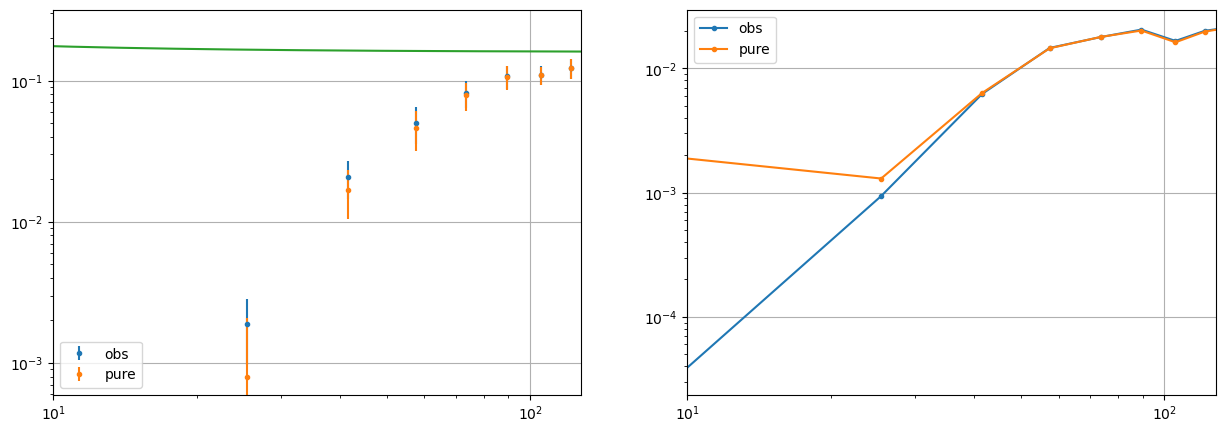

In [74]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].errorbar(ells, c2db*mean, c2db*std, fmt='.', label='obs')
axes[0].errorbar(ells, c2db*mean_pure, c2db*std_pure, fmt='.', label='pure')
axes[0].plot(c2d*Cl_BBonly[2])

axes[1].plot(ells, c2db*std, marker='.', label='obs')
axes[1].plot(ells, c2db*std_pure, marker='.', label='pure')

for ax in axes.flatten():
    ax.set_xlim([10, 2*nside])
    ax.loglog()
    ax.legend()
    ax.grid()